In [1]:
## fishing or not fishing 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from urllib.parse import urlparse
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score

In [2]:
df=pd.read_csv('phishing_url_dataset_unique.csv')
df.head()

,url,label,source
0,http://110.37.26.193:54956/bin.sh,1,urlhaus
1,https://sentry5.obor1shwron8.ru/4ylkytvt,1,urlhaus
2,https://d6gu.ripple-cask.ru/jid43vpd,1,urlhaus
3,http://130.12.180.34/596a96cc7bf9108cd896f33c4...,1,urlhaus
4,https://bronze.systems,0,tranco


In [4]:
from ydata_profiling import ProfileReport
profile=ProfileReport(df,title="Phishing URL Dataset Profiling Report",explorative=True)
profile.to_file("phishing_url_dataset_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  4.26it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.describe()

,label
count,48812.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [6]:
df['label'].value_counts()

label
1    24406
0    24406
Name: count, dtype: int64

In [7]:
def extract_features(url):
    features={}
    features['url_length']=len(url)
    features['digit_count']=sum(c.isdigit() for c in url)
    features['special_char_count']=len(re.findall(r'[^a-zA-Z0-9]', url))
    features['has_https']=1 if url.startswith('https') else 0
    features['has_ip']=1 if re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', url) else 0
    parsed_url=urlparse(url)
    return pd.Series(features)
url_features=df['url'].apply(extract_features)
df_features=pd.concat([df, url_features], axis=1)
df_features.head()


,url,label,source,url_length,digit_count,special_char_count,has_https,has_ip
0,http://110.37.26.193:54956/bin.sh,1,urlhaus,33,15,9,0,1
1,https://sentry5.obor1shwron8.ru/4ylkytvt,1,urlhaus,40,4,6,1,0
2,https://d6gu.ripple-cask.ru/jid43vpd,1,urlhaus,36,3,7,1,0
3,http://130.12.180.34/596a96cc7bf9108cd896f33c4...,1,urlhaus,91,46,9,0,1
4,https://bronze.systems,0,tranco,22,0,4,1,0


/var/folders/79/qf4s258d1979pqm6v_z63bmc0000gn/T/ipykernel_8613/2221724584.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_features, x='label', y='url_length',palette='Set2')


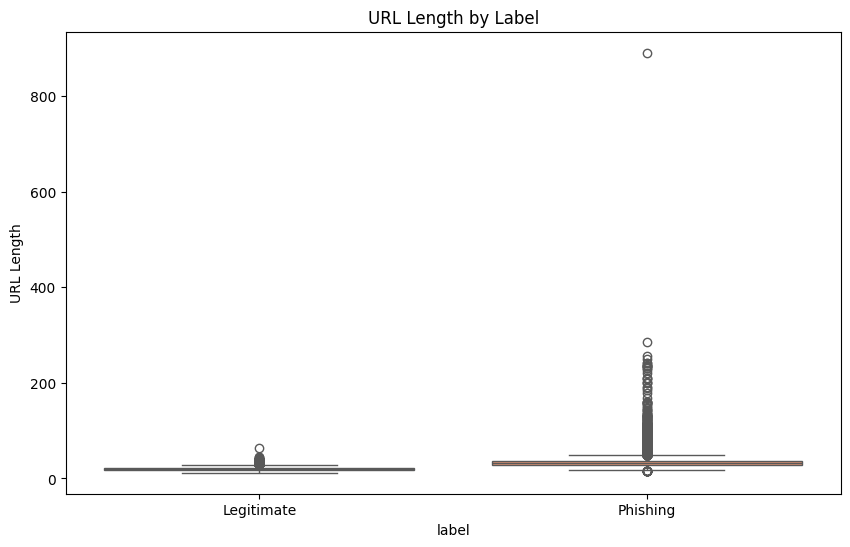

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_features, x='label', y='url_length',palette='Set2')
plt.xticks([0,1], ['Legitimate', 'Phishing'])
plt.ylabel('URL Length')
plt.title('URL Length by Label')
plt.show()

In [ ]:
tfidf=TfidfVectorizer(max_features=5000,ngram_range=(1,2),analyzer="char")


In [10]:
X_train,X_test,y_train,y_tyest=train_test_split(df_features['url'],df_features['label'],test_size=0.2,random_state=42)

In [13]:
# Vectorize URLs for model input
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Fix typo from previous cell
y_test = y_tyest

lr=LogisticRegression(max_iter=1000,
                     class_weight='balanced',
                    solver='liblinear',
                    penalty='l2',
                    C=1.0,
                    fit_intercept=True)
lr.fit(X_train_tfidf,y_train)
y_pred_lr=lr.predict(X_test_tfidf)
print("Logistic Regression Classification Report:")
print(classification_report(y_test,y_pred_lr))
roc_auc_lr=roc_auc_score(y_test,lr.predict_proba(X_test_tfidf)[:,1])
print(f"Logistic Regression ROC-AUC Score: {roc_auc_lr:.4f}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4786
           1       1.00      1.00      1.00      4977

    accuracy                           1.00      9763
   macro avg       1.00      1.00      1.00      9763
weighted avg       1.00      1.00      1.00      9763

Logistic Regression ROC-AUC Score: 0.9999


In [16]:
rf=RandomForestClassifier(n_estimators=100,
                          class_weight='balanced',
                            max_depth=2,
                            n_jobs=-1,
                            random_state=42,
                            criterion='gini'
                            )
rf.fit(X_train_tfidf,y_train)
y_pred=rf.predict(X_test)
y_pred_rf=rf.predict(X_test)[:,1]
print("Random Forest Classification Report:")
print(classification_report(y_test,y_pred))
roc_auc_rf=roc_auc_score(y_test,rf.predict_proba(X_test_tfidf)[:,1])
print(f"Random Forest ROC-AUC Score: {roc_auc_rf:.4f}")

ValueError: could not convert string to float: 'https://twingate.com'